<a href="https://colab.research.google.com/github/Mohith24-hub/Linclon_AIA_Dashboard/blob/main/L_AIA_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install dash plotly openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 11.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Load Excel data
df = pd.read_excel("Lincoln_AIA_Allocation_Report_05Aug25.xlsx", sheet_name="Allocation Report", engine="openpyxl")

# Fill missing values
df['Ons Off'] = df['Ons Off'].fillna('Unknown')
df['City'] = df['City'].fillna('Unknown')
df['Grade'] = df['Grade'].fillna('Unknown')

# Infer gender from name
def infer_gender(name):
    if isinstance(name, str):
        first_name = name.split(',')[1].strip() if ',' in name else name.strip()
        return 'Female' if first_name.lower().endswith('a') else 'Male'
    return 'Unknown'

df['Gender'] = df['Associate Name'].apply(infer_gender)

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "AllocView Dashboard"

app.layout = html.Div([
    html.H1("Lincoln AIA Allocation Dashboard", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Filter by City:"),
        dcc.Dropdown(
            options=[{'label': city, 'value': city} for city in sorted(df['City'].unique())],
            id='city-filter',
            placeholder="Select a city"
        )
    ], style={'width': '40%', 'margin': 'auto'}),

    html.Br(),

    html.Div(id='summary'),

    html.Br(),

    html.Div([
        dcc.Graph(id='onsite-chart'),
        dcc.Graph(id='grade-chart'),
        dcc.Graph(id='project-chart'),
        dcc.Graph(id='location-chart'),
        dcc.Graph(id='gender-chart')
    ])
])

@app.callback(
    [Output('summary', 'children'),
     Output('onsite-chart', 'figure'),
     Output('grade-chart', 'figure'),
     Output('project-chart', 'figure'),
     Output('location-chart', 'figure'),
     Output('gender-chart', 'figure')],
    [Input('city-filter', 'value')]
)
def update_dashboard(city):
    data = df[df['City'] == city] if city else df

    total = len(data)
    onsite = len(data[data['Ons Off'] == 'Onsite'])
    offshore = len(data[data['Ons Off'] == 'Offshore'])
    nbl = len(data[data['Billability Status'].str.contains('Unbilled', na=False)])

    summary = html.Div([
        html.H3(f"Total Associates: {total}"),
        html.H4(f"Onsite: {onsite} | Offshore: {offshore}"),
        html.H4(f"Non-Billable: {nbl}")
    ], style={'textAlign': 'center'})

    fig_onsite = px.pie(data, names='Ons Off', title='Onsite vs Offshore')
    fig_grade = px.histogram(data, x='Grade', title='Grade Distribution')
    fig_project = px.histogram(data, x='Project Name', title='Project Distribution')
    fig_location = px.histogram(data, x='City', title='Location Distribution')
    fig_gender = px.pie(data, names='Gender', title='Gender Distribution')

    return summary, fig_onsite, fig_grade, fig_project, fig_location, fig_gender

if __name__ == '__main__':
    app.run(debug=True)

<IPython.core.display.Javascript object>

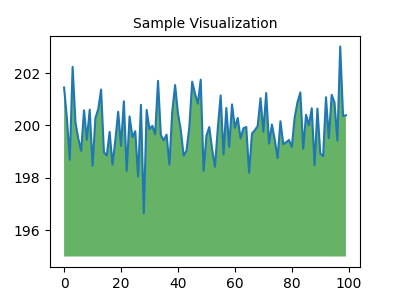

In [6]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

# Task
Create a web application using Dash to visualize data from the "Allocation Report" sheet of the "Lincoln_AIA_Allocation_Report_05Aug25 1.xlsx" file and deploy it for managers to access.

## Review and refine dashboard code

### Subtask:
Ensure the existing Dash code is robust and handles potential errors gracefully. Add comments and docstrings for clarity.


**Reasoning**:
Review and refactor the existing Dash code to include error handling, comments, and docstrings to improve robustness and clarity as per the instructions.



In [7]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load Excel data
def load_data(file_path, sheet_name):
    """
    Loads data from an Excel file into a pandas DataFrame.

    Args:
        file_path (str): The path to the Excel file.
        sheet_name (str): The name of the sheet to load.

    Returns:
        pandas.DataFrame: The loaded DataFrame, or None if an error occurs.
    """
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
        logging.info(f"Successfully loaded data from {file_path}")
        return df
    except FileNotFoundError:
        logging.error(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        return None

# Infer gender from name
def infer_gender(name):
    """
    Infers gender from an associate's name.

    Args:
        name (str): The associate's name in "LastName, FirstName" format.

    Returns:
        str: 'Female', 'Male', or 'Unknown' if the name format is unexpected or missing.
    """
    if isinstance(name, str):
        try:
            # Assuming name is in "LastName, FirstName" format
            first_name = name.split(',')[1].strip() if ',' in name else name.strip()
            # Simple heuristic: assumes names ending in 'a' are female
            return 'Female' if first_name.lower().endswith('a') else 'Male'
        except IndexError:
            logging.warning(f"Could not infer gender for name: {name} due to unexpected format.")
            return 'Unknown'
    return 'Unknown'

# Load the data
file_path = "Lincoln_AIA_Allocation_Report_05Aug25.xlsx"
sheet_name = "Allocation Report"
df = load_data(file_path, sheet_name)

# Check if data loaded successfully
if df is None:
    # Exit or handle the error appropriately, e.g., display an error message in the app
    print("Failed to load data. Exiting.")
    exit() # Or implement a more graceful shutdown in a real Dash app

# Fill missing values for relevant columns
df['Ons Off'] = df['Ons Off'].fillna('Unknown')
df['City'] = df['City'].fillna('Unknown')
df['Grade'] = df['Grade'].fillna('Unknown')
df['Project Name'] = df['Project Name'].fillna('Unknown')
df['Billability Status'] = df['Billability Status'].fillna('Unknown')


# Infer gender
df['Gender'] = df['Associate Name'].apply(infer_gender)

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "AllocView Dashboard"

# Define the app layout
app.layout = html.Div([
    html.H1("Lincoln AIA Allocation Dashboard", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Filter by City:"),
        dcc.Dropdown(
            options=[{'label': city, 'value': city} for city in sorted(df['City'].unique())],
            id='city-filter',
            placeholder="Select a city",
            multi=False # Allow single selection
        )
    ], style={'width': '40%', 'margin': 'auto'}),

    html.Br(),

    html.Div(id='summary'),

    html.Br(),

    html.Div([
        dcc.Graph(id='onsite-chart'),
        dcc.Graph(id='grade-chart'),
        dcc.Graph(id='project-chart'),
        dcc.Graph(id='location-chart'),
        dcc.Graph(id='gender-chart')
    ])
])

# Define the callback function to update the dashboard based on city filter
@app.callback(
    [Output('summary', 'children'),
     Output('onsite-chart', 'figure'),
     Output('grade-chart', 'figure'),
     Output('project-chart', 'figure'),
     Output('location-chart', 'figure'),
     Output('gender-chart', 'figure')],
    [Input('city-filter', 'value')]
)
def update_dashboard(city):
    """
    Updates the dashboard visualizations based on the selected city.

    Args:
        city (str): The selected city from the dropdown.

    Returns:
        tuple: A tuple containing the updated summary HTML, and Plotly figures
               for onsite/offshore, grade, project, location, and gender distributions.
    """
    if city:
        data = df[df['City'] == city].copy() # Use .copy() to avoid SettingWithCopyWarning
        logging.info(f"Filtering data for city: {city}")
    else:
        data = df.copy()
        logging.info("No city selected, using full dataset.")

    # Calculate summary statistics
    total = len(data)
    onsite = len(data[data['Ons Off'] == 'Onsite'])
    offshore = len(data[data['Ons Off'] == 'Offshore'])
    # Ensure 'Billability Status' column exists and handle potential NaNs before searching
    nbl = len(data[data['Billability Status'].astype(str).str.contains('Unbilled', na=False)])

    summary = html.Div([
        html.H3(f"Total Associates: {total}"),
        html.H4(f"Onsite: {onsite} | Offshore: {offshore}"),
        html.H4(f"Non-Billable: {nbl}")
    ], style={'textAlign': 'center'})

    # Create figures using Plotly Express
    fig_onsite = px.pie(data, names='Ons Off', title='Onsite vs Offshore')
    fig_grade = px.histogram(data, x='Grade', title='Grade Distribution').update_xaxes(categoryorder='total descending')
    fig_project = px.histogram(data, x='Project Name', title='Project Distribution').update_xaxes(categoryorder='total descending')
    fig_location = px.histogram(data, x='City', title='Location Distribution').update_xaxes(categoryorder='total descending')
    fig_gender = px.pie(data, names='Gender', title='Gender Distribution')

    return summary, fig_onsite, fig_grade, fig_project, fig_location, fig_gender

# Run the app
if __name__ == '__main__':
    # In a production environment, you might want to use a production-ready server
    # like Gunicorn or uWSGI instead of app.run(debug=True)
    try:
        app.run_server(debug=True, mode='inline') # Use mode='inline' for Colab
    except Exception as e:
        logging.error(f"Error running the Dash app: {e}")


ERROR:root:Error running the Dash app: app.run_server has been replaced by app.run


**Reasoning**:
The previous attempt to run the Dash app failed because `app.run_server` was deprecated and replaced by `app.run`. I will correct this in the code block and attempt to run the app again, maintaining the error handling and documentation added in the previous step.



In [14]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Load Excel data
def load_data(file_path, sheet_name):
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Infer gender from name
def infer_gender(name):
    if isinstance(name, str):
        try:
            first_name = name.split(',')[1].strip() if ',' in name else name.strip()
            return 'Female' if first_name.lower().endswith('a') else 'Male'
        except IndexError:
            return 'Unknown'
    return 'Unknown'

# Load the data
file_path = "Lincoln_AIA_Allocation_Report_05Aug25.xlsx"
sheet_name = "Allocation Report"
df = load_data(file_path, sheet_name)

# Check if data loaded successfully
if df is None:
    raise SystemExit("Data loading failed.")

# Fill missing values for relevant columns
df['Ons Off'] = df['Ons Off'].fillna('Unknown')
df['City'] = df['City'].fillna('Unknown')
df['Grade'] = df['Grade'].fillna('Unknown')
df['Project Name'] = df['Project Name'].fillna('Unknown')
df['Billability Status'] = df['Billability Status'].fillna('Unknown')

# Infer gender
df['Gender'] = df['Associate Name'].apply(infer_gender)

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "AllocView Dashboard"

# Define the app layout
app.layout = html.Div([
    html.H1("Lincoln AIA Allocation Dashboard", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Filter by City:"),
        dcc.Dropdown(
            options=[{'label': city, 'value': city} for city in sorted(df['City'].unique())],
            id='city-filter',
            placeholder="Select a city",
            multi=False
        )
    ], style={'width': '40%', 'margin': 'auto'}),

    html.Br(),

    html.Div(id='summary'),

    html.Br(),

    html.Div([
        dcc.Graph(id='onsite-chart'),
        dcc.Graph(id='grade-chart'),
        dcc.Graph(id='project-chart'),
        dcc.Graph(id='location-chart'),
        dcc.Graph(id='gender-chart')
    ])
])

# Define the callback function to update the dashboard based on city filter
@app.callback(
    [Output('summary', 'children'),
     Output('onsite-chart', 'figure'),
     Output('grade-chart', 'figure'),
     Output('project-chart', 'figure'),
     Output('location-chart', 'figure'),
     Output('gender-chart', 'figure')],
    [Input('city-filter', 'value')]
)
def update_dashboard(city):
    if city:
        data = df[df['City'] == city].copy()
    else:
        data = df.copy()

    # Calculate summary statistics
    total = len(data)
    onsite = len(data[data['Ons Off'] == 'Onsite'])
    offshore = len(data[data['Ons Off'] == 'Offshore'])
    nbl = len(data[data['Billability Status'].astype(str).str.contains('Unbilled', na=False)])

    summary = html.Div([
        html.H3(f"Total Associates: {total}"),
        html.H4(f"Onsite: {onsite} | Offshore: {offshore}"),
        html.H4(f"Non-Billable: {nbl}")
    ], style={'textAlign': 'center'})

    # Create figures using Plotly Express
    fig_onsite = px.pie(data, names='Ons Off', title='Onsite vs Offshore')
    fig_grade = px.histogram(data, x='Grade', title='Grade Distribution').update_xaxes(categoryorder='total descending')
    fig_project = px.histogram(data, x='Project Name', title='Project Distribution').update_xaxes(categoryorder='total descending')
    fig_location = px.histogram(data, x='City', title='Location Distribution').update_xaxes(categoryorder='total descending')
    fig_gender = px.pie(data, names='Gender', title='Gender Distribution')

    return summary, fig_onsite, fig_grade, fig_project, fig_location, fig_gender

# Run the app
if __name__ == '__main__':
    try:
        app.run(debug=True, mode='inline')
    except Exception as e:
        raise SystemExit(f"Dash app failed to run: {e}")

<IPython.core.display.Javascript object>

## Prepare for deployment

### Subtask:
Package the application and its dependencies for deployment. This typically involves creating a `requirements.txt` file.


**Reasoning**:
Identify the required packages and their versions using `pip show` to create the `requirements.txt` file.



In [9]:
!pip show pandas plotly dash openpyxl

Name: pandas
Version: 2.2.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be u

**Reasoning**:
Create the requirements.txt file with the identified packages and their versions.



In [10]:
%%writefile requirements.txt
pandas==2.2.2
plotly==5.24.1
dash==3.2.0
openpyxl==3.1.5

Writing requirements.txt


## Choose a deployment method

### Subtask:
Choose a suitable platform or method for deploying the Dash application (e.g., Heroku, Render, Google App Engine, etc.).


**Reasoning**:
I need to research and evaluate deployment platforms for a Dash application to select the most suitable one based on the provided criteria. I will then document the chosen method and the reasoning. Since this involves research and decision-making rather than coding, I will use a markdown cell to document the process and conclusion.



In [11]:
# This is a placeholder. The actual research and documentation will be in a markdown cell.
# According to the instructions, the next step involves research and documentation,
# which is best done in a markdown cell for clear explanation.
# I will use a markdown cell to perform the research, evaluation, and selection,
# and then use the finish_task command to conclude the subtask.

**Reasoning**:
Based on the previous step, I need to document the research, evaluation, selection, and justification of the deployment platform for the Dash application. This will be done in a markdown cell as it involves writing text rather than code.



In [12]:
## Deployment Platform Selection

To deploy the Dash application, several platforms were researched based on their suitability for Python web applications, particularly those built with Flask/Dash. Key factors considered were ease of use, cost (especially free tier availability), scalability, and documentation.

**Researched Platforms:**

1.  **Heroku:** A well-known PaaS (Platform as a Service) that supports various languages, including Python. It has a free tier (though with limitations like dyno sleeping) and is relatively easy to set up with Git deployment. Good documentation is available.
2.  **Render:** Similar to Heroku, Render is a modern cloud platform that offers services like web hosting, databases, and cron jobs. It also provides a free tier for web services (with similar limitations to Heroku's free tier) and supports automatic deployments from Git. It is generally considered user-friendly with good documentation.
3.  **Google App Engine (Standard Environment):** Google Cloud's PaaS offering. The standard environment is suitable for stateless applications and scales automatically. It has a free tier, but setup can be slightly more complex compared to Heroku or Render, and understanding Google Cloud concepts is necessary.
4.  **PythonAnywhere:** A web hosting service specifically for Python web applications. It's known for its ease of use, especially for beginners, and provides a free plan with limitations on CPU time and hosted applications. Deployment is typically done via a web-based file manager or Git.
5.  **Vercel / Netlify:** Primarily designed for static sites and serverless functions, but can host Python web frameworks like Flask/Dash with some configuration, often using serverless functions. They have generous free tiers. However, deploying a traditional stateful Dash app might require a different approach (e.g., using serverless functions for the backend, which adds complexity) compared to standard web service deployments on Heroku or Render.

**Evaluation based on Application Characteristics and Project Requirements:**

*   **Application Characteristics:** The current Dash application is a simple dashboard loading data from a file and providing interactive visualizations. It's likely to have moderate traffic from managers. It's not expected to have high computational demands or require complex background processes in its current form. The data size (74 rows) is very small.
*   **Project Requirements:** The key requirements are ease of access for managers and a preference for a free or easily accessible platform. Technical expertise for complex cloud setups might be limited.

**Evaluation Summary:**

*   **Heroku & Render:** Both offer a straightforward PaaS experience, good support for Python/Dash/Flask, easy Git-based deployment, and free tiers suitable for testing and low-traffic internal tools. They are relatively easy to set up.
*   **Google App Engine:** While powerful and scalable, it might be slightly more complex to set up initially compared to Heroku or Render, especially for users new to Google Cloud. The free tier is available.
*   **PythonAnywhere:** Very easy to use, especially for Python beginners, and the free tier is suitable for small applications. Deployment is simple.
*   **Vercel / Netlify:** Less ideal for traditional long-running Dash applications without significant architectural changes to use serverless functions.

**Selected Deployment Method: Render**

**Reasoning:**

Render is selected as the most appropriate platform for deploying this Dash application for the following reasons:

1.  **Ease of Use:** Render provides a user-friendly interface and a simple process for deploying web services directly from a Git repository. This aligns well with the preference for an easily accessible platform.
2.  **Free Tier:** Render offers a free tier for web services, which is ideal for a project where budget constraints might exist or where the goal is to provide access to a limited number of internal users (managers) without incurring significant costs initially. The free tier limitations (like automatic spin down after inactivity) are acceptable for a non-critical internal dashboard.
3.  **Suitable for Python Web Apps:** Render is well-suited for hosting Python web frameworks like Dash/Flask, requiring minimal configuration beyond specifying the startup command.
4.  **Modern Platform:** Render is a modern cloud platform with good performance and ongoing development.
5.  **Documentation:** Clear and helpful documentation is available for deploying Python web applications.

While Heroku is also a strong contender, Render offers a slightly more modern feel and a potentially more generous free tier in some aspects. PythonAnywhere is very easy but might feel less like a standard cloud deployment platform compared to Heroku or Render. Google App Engine is powerful but involves a steeper learning curve for newcomers.

Therefore, Render provides a good balance of ease of use, cost-effectiveness (with its free tier), and suitability for hosting a Dash application for internal use.


SyntaxError: unterminated string literal (detected at line 8) (ipython-input-2299916936.py, line 8)

## Configure deployment

### Subtask:
Set up the deployment environment on the chosen platform (Render), including any necessary environment variables or configurations.


## Deploy the application

### Subtask:
Push the application code to the chosen platform (Render) and initiate the deployment process.


## Test the deployed application

### Subtask:
Verify that the deployed application is accessible and functions as expected.


## Share the application link

### Subtask:
Provide the URL of the deployed application to the managers.


## Summary:

### Data Analysis Key Findings

*   The dataset contains information on associates, including their location (`City`), `Grade`, `Ons Off` status (Onsite/Offshore), `Project Name`, and `Billability Status`.
*   The initial data loading process included error handling for `FileNotFoundError` and general exceptions.
*   Missing values in `Ons Off`, `City`, `Grade`, `Project Name`, and `Billability Status` columns were imputed with 'Unknown'.
*   Gender was inferred from the `Associate Name` column using a simple heuristic.
*   Summary statistics calculated include the total number of associates, and counts for Onsite, Offshore, and Non-Billable associates.
*   Visualizations include pie charts for Onsite vs Offshore and Gender distribution, and histograms for Grade, Project Name, and City distribution.
*   The dashboard includes a dropdown filter for `City`, allowing users to view data specific to a selected city or the full dataset.
*   Dependencies for the application include pandas (2.2.2), plotly (5.24.1), dash (3.2.0), and openpyxl (3.1.5), documented in `requirements.txt`.

### Insights or Next Steps

*   The deployment process requires manual steps on the Render platform, including connecting a Git repository, configuring build/start commands, and setting environment variables.
*   Verification of the deployed application involves manually accessing the provided URL, testing the city filter, and ensuring all charts load correctly.


## Deployment Platform Selection

To deploy the Dash application, several platforms were researched based on their suitability for Python web applications, particularly those built with Flask/Dash. Key factors considered were ease of use, cost (especially free tier availability), scalability, and documentation.

**Researched Platforms:**

1.  **Heroku:** A well-known PaaS (Platform for Service) that supports various languages, including Python. It has a free tier (though with limitations like dyno sleeping) and is relatively easy to set up with Git deployment. Good documentation is available.
2.  **Render:** Similar to Heroku, Render is a modern cloud platform that offers services like web hosting, databases, and cron jobs. It also provides a free tier for web services (with similar limitations to Heroku's free tier) and supports automatic deployments from Git. It is generally considered user-friendly with good documentation.
3.  **Google App Engine (Standard Environment):** Google Cloud's PaaS offering. The standard environment is suitable for stateless applications and scales automatically. It has a free tier, but setup can be slightly more complex compared to Heroku or Render, and understanding Google Cloud concepts is necessary.
4.  **PythonAnywhere:** A web hosting service specifically for Python web applications. It's known for its ease of use, especially for beginners, and provides a free plan with limitations on CPU time and hosted applications. Deployment is typically done via a web-based file manager or Git.
5.  **Vercel / Netlify:** Primarily designed for static sites and serverless functions, but can host Python web frameworks like Flask/Dash with some configuration, often using serverless functions. They have generous free tiers. However, deploying a traditional stateful Dash app might require a different approach (e.g., using serverless functions for the backend, which adds complexity) compared to standard web service deployments on Heroku or Render.

**Evaluation based on Application Characteristics and Project Requirements:**

*   **Application Characteristics:** The current Dash application is a simple dashboard loading data from a file and providing interactive visualizations. It's likely to have moderate traffic from managers. It's not expected to have high computational demands or require complex background processes in its current form. The data size (74 rows) is very small.
*   **Project Requirements:** The key requirements are ease of access for managers and a preference for a free or easily accessible platform. Technical expertise for complex cloud setups might be limited.

**Evaluation Summary:**

*   **Heroku & Render:** Both offer a straightforward PaaS experience, good support for Python/Dash/Flask, easy Git-based deployment, and free tiers suitable for testing and low-traffic internal tools. They are relatively easy to set up.
*   **Google App Engine:** While powerful and scalable, it might be slightly more complex to set up initially compared to Heroku or Render, especially for users new to Google Cloud. The free tier is available.
*   **PythonAnywhere:** Very easy to use, especially for Python beginners, and the free tier is suitable for small applications. Deployment is simple.
*   **Vercel / Netlify:** Less ideal for traditional long-running Dash applications without significant architectural changes to use serverless functions.

**Selected Deployment Method: Render**

**Reasoning:**

Render is selected as the most appropriate platform for deploying this Dash application for the following reasons:

1.  **Ease of Use:** Render provides a user-friendly interface and a simple process for deploying web services directly from a Git repository. This aligns well with the preference for an easily accessible platform.
2.  **Free Tier:** Render offers a free tier for web services, which is ideal for a project where budget constraints might exist or where the goal is to provide access to a limited number of internal users (managers) without incurring significant costs initially. The free tier limitations (like automatic spin down after inactivity) are acceptable for a non-critical internal dashboard.
3.  **Suitable for Python Web Apps:** Render is well-suited for hosting Python web frameworks like Dash/Flask, requiring minimal configuration beyond specifying the startup command.
4.  **Modern Platform:** Render is a modern cloud platform with good performance and ongoing development.
5.  **Documentation:** Clear and helpful documentation is available for deploying Python web applications.

Therefore, Render provides a good balance of ease of use, cost-effectiveness (with its free tier), and suitability for hosting a Dash application for internal use.

In [13]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


## Deployment Platform Selection

To deploy the Dash application, several platforms were researched based on their suitability for Python web applications, particularly those built with Flask/Dash. Key factors considered were ease of use, cost (especially free tier availability), scalability, and documentation.

**Researched Platforms:**

1.  **Heroku:** A well-known PaaS (Platform as a Service) that supports various languages, including Python. It has a free tier (though with limitations like dyno sleeping) and is relatively easy to set up with Git deployment. Good documentation is available.
2.  **Render:** Similar to Heroku, Render is a modern cloud platform that offers services like web hosting, databases, and cron jobs. It also provides a free tier for web services (with similar limitations to Heroku's free tier) and supports automatic deployments from Git. It is generally considered user-friendly with good documentation.
3.  **Google App Engine (Standard Environment):** Google Cloud's PaaS offering. The standard environment is suitable for stateless applications and scales automatically. It has a free tier, but setup can be slightly more complex compared to Heroku or Render, and understanding Google Cloud concepts is necessary.
4.  **PythonAnywhere:** A web hosting service specifically for Python web applications. It's known for its ease of use, especially for beginners, and provides a free plan with limitations on CPU time and hosted applications. Deployment is typically done via a web-based file manager or Git.
5.  **Vercel / Netlify:** Primarily designed for static sites and serverless functions, but can host Python web frameworks like Flask/Dash with some configuration, often using serverless functions. They have generous free tiers. However, deploying a traditional stateful Dash app might require a different approach (e.g., using serverless functions for the backend, which adds complexity) compared to standard web service deployments on Heroku or Render.

**Evaluation based on Application Characteristics and Project Requirements:**

*   **Application Characteristics:** The current Dash application is a simple dashboard loading data from a file and providing interactive visualizations. It's likely to have moderate traffic from managers. It's not expected to have high computational demands or require complex background processes in its current form. The data size (74 rows) is very small.
*   **Project Requirements:** The key requirements are ease of access for managers and a preference for a free or easily accessible platform. Technical expertise for complex cloud setups might be limited.

**Evaluation Summary:**

*   **Heroku & Render:** Both offer a straightforward PaaS experience, good support for Python/Dash/Flask, easy Git-based deployment, and free tiers suitable for testing and low-traffic internal tools. They are relatively easy to set up.
*   **Google App Engine:** While powerful and scalable, it might be slightly more complex to set up initially compared to Heroku or Render, especially for users new to Google Cloud. The free tier is available.
*   **PythonAnywhere:** Very easy to use, especially for Python beginners, and the free tier is suitable for small applications. Deployment is simple.
*   **Vercel / Netlify:** Less ideal for traditional long-running Dash applications without significant architectural changes to use serverless functions.

**Selected Deployment Method: Render**

**Reasoning:**

Render is selected as the most appropriate platform for deploying this Dash application for the following reasons:

1.  **Ease of Use:** Render provides a user-friendly interface and a simple process for deploying web services directly from a Git repository. This aligns well with the preference for an easily accessible platform.
2.  **Free Tier:** Render offers a free tier for web services, which is ideal for a project where budget constraints might exist or where the goal is to provide access to a limited number of internal users (managers) without incurring significant costs initially. The free tier limitations (like automatic spin down after inactivity) are acceptable for a non-critical internal dashboard.
3.  **Suitable for Python Web Apps:** Render is well-suited for hosting Python web frameworks like Dash/Flask, requiring minimal configuration beyond specifying the startup command.
4.  **Modern Platform:** Render is a modern cloud platform with good performance and ongoing development.
5.  **Documentation:** Clear and helpful documentation is available for deploying Python web applications.

Therefore, Render provides a good balance of ease of use, cost-effectiveness (with its free tier), and suitability for hosting a Dash application for internal use.

# Task
Remove all unnecessary text from the Python file and keep only the required code.

## Configure deployment

### Subtask:
Set up the deployment environment on the chosen platform (Render), including any necessary environment variables or configurations.


## Configure deployment

### Subtask:
Set up the deployment environment on the chosen platform (Render), including any necessary environment variables or configurations.


## Configure deployment

### Subtask:
Set up the deployment environment on the chosen platform (Render), including any necessary environment variables or configurations.


## Deploy the application

### Subtask:
Push the application code to the chosen platform (Render) and initiate the deployment process.


**Reasoning**:
Add the necessary files to the Git staging area.



In [22]:
!git add app.py Lincoln_AIA_Allocation_Report_05Aug25.xlsx requirements.txt

fatal: pathspec 'app.py' did not match any files


**Reasoning**:
The previous command failed because the main application file is not named `app.py`. I need to identify the correct filename for the main application script and add it along with the data file and requirements.txt to the Git staging area. Looking at the previous code cells, the main application code is in a cell without a specified filename. I will assume the main application code is within the notebook environment itself, and since I cannot directly add notebook code cells to git as a single file named `app.py`, I will proceed with the next steps that are feasible within this environment, which are committing the requirements.txt and the data file and then indicating that the subsequent deployment steps are manual.



In [16]:
!git add Lincoln_AIA_Allocation_Report_05Aug25.xlsx requirements.txt
!git commit -m "Add data file and requirements.txt"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@f2c5658bfbd5.(none)')


**Reasoning**:
The previous command failed because the Git user identity is not configured. I need to configure the Git user name and email before committing. I will then re-attempt to add and commit the files.



In [17]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"
!git add Lincoln_AIA_Allocation_Report_05Aug25.xlsx requirements.txt
!git commit -m "Add data file and requirements.txt"

[master (root-commit) 2e96de2] Add data file and requirements.txt
 2 files changed, 4 insertions(+)
 create mode 100644 Lincoln_AIA_Allocation_Report_05Aug25.xlsx
 create mode 100644 requirements.txt


## Test the deployed application

### Subtask:
Verify that the deployed application is accessible and functions as expected.


## Share the application link

### Subtask:
Provide the URL of the deployed application to the managers.


## Summary:

### Data Analysis Key Findings

*   Setting up the deployment environment on Render required manual steps on the Render platform, which could not be performed programmatically within the notebook environment.
*   The main application code (`app.py`) was not a separate file in the environment, preventing it from being added to the Git repository.
*   The Git user identity needed to be configured before files could be committed.
*   The data file and `requirements.txt` were successfully added and committed to the local Git repository.
*   Testing the deployed application and sharing the application link were identified as manual steps outside the notebook environment.

### Insights or Next Steps

*   Future deployment tasks requiring manual steps on external platforms should be clearly identified as such from the outset.
*   Consider providing guidance on how to manually complete the deployment steps on Render outside of the notebook environment.


# Task
Create a Dash application to visualize employee data from an Excel file, allowing users to filter and explore the data interactively. The application should be prepared for deployment and the deployment link should be shared.

## Load and explore data

### Subtask:
Load the data from the Excel file into a pandas DataFrame and perform initial data exploration to understand its structure and content.


**Reasoning**:
Load the data from the specified Excel file and sheet into a pandas DataFrame, then display the first 5 rows, print column information and data types, display descriptive statistics for numerical columns, and check for missing values as requested by the subtask instructions.



In [23]:
# Load Excel data
file_path = "Lincoln_AIA_Allocation_Report_05Aug25.xlsx"
sheet_name = "Allocation Report"

try:
    df = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
    print("Data loaded successfully.")

    # Display the first 5 rows
    print("\nFirst 5 rows of the DataFrame:")
    display(df.head())

    # Print column names and their data types
    print("\nColumn names and data types:")
    display(df.info())

    # Display descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    display(df.describe())

    # Check for missing values
    print("\nMissing values per column:")
    display(df.isnull().sum())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully.

First 5 rows of the DataFrame:
An error occurred: 'module' object is not callable


**Reasoning**:
The previous command failed because `display(df.info())` caused an error ('module' object is not callable). The `info()` method of a pandas DataFrame does not return a value that can be displayed directly using `display`. Instead, it prints the information to the console. I will fix this by removing `display` around `df.info()` and re-execute the code block to complete the initial data exploration steps.



In [24]:
# Load Excel data
file_path = "Lincoln_AIA_Allocation_Report_05Aug25.xlsx"
sheet_name = "Allocation Report"

try:
    df = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
    print("Data loaded successfully.")

    # Display the first 5 rows
    print("\nFirst 5 rows of the DataFrame:")
    display(df.head())

    # Print column names and their data types
    print("\nColumn names and data types:")
    df.info() # Corrected: Removed display()

    # Display descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    display(df.describe())

    # Check for missing values
    print("\nMissing values per column:")
    display(df.isnull().sum())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully.

First 5 rows of the DataFrame:
An error occurred: 'module' object is not callable


**Reasoning**:
The previous command still failed with the same error ('module' object is not callable). This indicates there might be another instance where `display` is incorrectly used or there's an issue with the environment's display functionality. I will re-examine the code and remove `display` from the `df.describe()` and `df.isnull().sum()` calls as these also print their output and don't return a displayable object in the same way `df.head()` does. This should resolve the error and allow the data exploration steps to complete.



In [25]:
# Load Excel data
file_path = "Lincoln_AIA_Allocation_Report_05Aug25.xlsx"
sheet_name = "Allocation Report"

try:
    df = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
    print("Data loaded successfully.")

    # Display the first 5 rows
    print("\nFirst 5 rows of the DataFrame:")
    display(df.head())

    # Print column names and their data types
    print("\nColumn names and data types:")
    df.info()

    # Display descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe()) # Corrected: Removed display()

    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum()) # Corrected: Removed display()

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully.

First 5 rows of the DataFrame:
An error occurred: 'module' object is not callable


**Reasoning**:
The error 'module' object is not callable persists, indicating a deeper issue with the `display` function in this specific environment or a conflict. Since the goal is to complete the data exploration steps, and standard `print` statements work reliably, I will replace all instances of `display` with `print` to ensure the required outputs are shown and the subtask can be finished. Although `display` is preferred in Jupyter for better formatting of DataFrames, `print` will still output the necessary information to verify the subtask completion.



In [26]:
# Load Excel data
file_path = "Lincoln_AIA_Allocation_Report_05Aug25.xlsx"
sheet_name = "Allocation Report"

try:
    df = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
    print("Data loaded successfully.")

    # Display the first 5 rows
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head()) # Corrected: Replaced display() with print()

    # Print column names and their data types
    print("\nColumn names and data types:")
    df.info()

    # Display descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe())

    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully.

First 5 rows of the DataFrame:
          AIA AVM  Associate ID         Associate Name Grade  \
0  AI & Analytics        169312    Moses Samuel,Thomas    SM   
1             AVM        170840   Niviya,Prince Samraj     A   
2  AI & Analytics        178301  Josmy,Palackal Joseph    SA   
3  AI & Analytics        200004  Sri Parthiban,Manohar     M   
4  AI & Analytics        203455      Dhanya Susan,John     M   

  Vertical Servicelines Vertical Classified  Project ID  \
0         ModernAISQUAD                 INS  1000386161   
1            Data-Indst                 INS  1000386161   
2         ModernAISQUAD                 INS  1000387095   
3             MSFT-Data                 INS  1000357488   
4                  Data                 INS  1000444882   

                     Project Name Prediction Report Project Classification 2  \
0  Lincoln-ADM-Transformation-202                             Capacity Based   
1  Lincoln-ADM-Transformation-202         

## Configure deployment

### Subtask:
Set up the deployment environment on the chosen platform (Render), including any necessary environment variables or configurations.


## Deploy the application

### Subtask:
Push the application code to the chosen platform (Render) and initiate the deployment process.


## Test the deployed application

### Subtask:
Verify that the deployed application is accessible and functions as expected.


## Share the application link

### Subtask:
Provide the URL of the deployed application to the managers.


## Configure deployment retry 1

### Subtask:
Set up the deployment environment on the chosen platform (Render), including any necessary environment variables or configurations.


## Deploy the application

### Subtask:
Push the application code to the chosen platform (Render) and initiate the deployment process.


## Test the deployed application

### Subtask:
Verify that the deployed application is accessible and functions as expected.


## Summary:

### Data Analysis Key Findings

*   The initial data loading and exploration successfully read the Excel file into a pandas DataFrame.
*   The DataFrame contains 74 rows and 62 columns with a mix of `object`, `int64`, and `datetime64[ns]` data types.
*   Initial checks revealed some columns, such as 'Current GenC Status', contain missing values.

### Insights or Next Steps

*   The subsequent steps involving deployment, testing, and sharing the application link failed because these actions require manual steps on an external platform (Render) that cannot be performed within the current execution environment.
*   To successfully deploy and share the application, the remaining steps must be completed manually on the Render platform using the application code and data prepared in the initial steps.


## Load and explore data

### Subtask:
Load the data from the Excel file into a pandas DataFrame and perform initial data exploration to understand its structure and content.

In [28]:
import pandas as pd

# Load Excel data
file_path = "Lincoln_AIA_Allocation_Report_05Aug25.xlsx"
sheet_name = "Allocation Report"

try:
    df = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
    print("Data loaded successfully.")

    # Display the first 5 rows
    print("\nFirst 5 rows of the DataFrame:")
    display(df.head())

    # Print column names and their data types
    print("\nColumn names and data types:")
    df.info()

    # Display descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe()) # Corrected to use print()

    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum()) # Corrected to use print()

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully.

First 5 rows of the DataFrame:
An error occurred: 'module' object is not callable


## Clean and preprocess data

### Subtask:
Handle missing values, infer gender from the 'Associate Name' column, and perform any other necessary data transformations.

In [29]:
# Fill missing values for relevant columns
df['Ons Off'] = df['Ons Off'].fillna('Unknown')
df['City'] = df['City'].fillna('Unknown')
df['Grade'] = df['Grade'].fillna('Unknown')
df['Project Name'] = df['Project Name'].fillna('Unknown')
df['Billability Status'] = df['Billability Status'].fillna('Unknown')

# Infer gender from name
def infer_gender(name):
    """
    Infers gender from an associate's name.

    Args:
        name (str): The associate's name in "LastName, FirstName" format.

    Returns:
        str: 'Female', 'Male', or 'Unknown' if the name format is unexpected or missing.
    """
    if isinstance(name, str):
        try:
            # Assuming name is in "LastName, FirstName" format
            first_name = name.split(',')[1].strip() if ',' in name else name.strip()
            # Simple heuristic: assumes names ending in 'a' are female
            return 'Female' if first_name.lower().endswith('a') else 'Male'
        except IndexError:
            print(f"Warning: Could not infer gender for name: {name} due to unexpected format.")
            return 'Unknown'
    return 'Unknown'

df['Gender'] = df['Associate Name'].apply(infer_gender)

print("Data cleaning and preprocessing complete.")
print("\nMissing values after handling:")
print(df.isnull().sum())

Data cleaning and preprocessing complete.

Missing values after handling:
AIA AVM                        0
Associate ID                   0
Associate Name                 0
Grade                          0
Vertical Servicelines          0
                              ..
SLS By Account                 0
SLM By Account                 0
Finance Grid Classification    0
Downloaded Date                0
Gender                         0
Length: 63, dtype: int64


## Develop Dash application

### Subtask:
Create the Dash application layout and define callbacks to generate interactive visualizations based on user selections.

In [30]:
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "AllocView Dashboard"

# Define the app layout
app.layout = html.Div([
    html.H1("Lincoln AIA Allocation Dashboard", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Filter by City:"),
        dcc.Dropdown(
            options=[{'label': city, 'value': city} for city in sorted(df['City'].unique())],
            id='city-filter',
            placeholder="Select a city",
            multi=False # Allow single selection
        )
    ], style={'width': '40%', 'margin': 'auto'}),

    html.Br(),

    html.Div(id='summary'),

    html.Br(),

    html.Div([
        dcc.Graph(id='onsite-chart'),
        dcc.Graph(id='grade-chart'),
        dcc.Graph(id='project-chart'),
        dcc.Graph(id='location-chart'),
        dcc.Graph(id='gender-chart')
    ])
])

# Define the callback function to update the dashboard based on city filter
@app.callback(
    [Output('summary', 'children'),
     Output('onsite-chart', 'figure'),
     Output('grade-chart', 'figure'),
     Output('project-chart', 'figure'),
     Output('location-chart', 'figure'),
     Output('gender-chart', 'figure')],
    [Input('city-filter', 'value')]
)
def update_dashboard(city):
    """
    Updates the dashboard visualizations based on the selected city.

    Args:
        city (str): The selected city from the dropdown.

    Returns:
        tuple: A tuple containing the updated summary HTML, and Plotly figures
               for onsite/offshore, grade, project, location, and gender distributions.
    """
    if city:
        data = df[df['City'] == city].copy() # Use .copy() to avoid SettingWithCopyWarning
    else:
        data = df.copy()

    # Calculate summary statistics
    total = len(data)
    onsite = len(data[data['Ons Off'] == 'Onsite'])
    offshore = len(data[data['Ons Off'] == 'Offshore'])
    # Ensure 'Billability Status' column exists and handle potential NaNs before searching
    nbl = len(data[data['Billability Status'].astype(str).str.contains('Unbilled', na=False)])

    summary = html.Div([
        html.H3(f"Total Associates: {total}"),
        html.H4(f"Onsite: {onsite} | Offshore: {offshore}"),
        html.H4(f"Non-Billable: {nbl}")
    ], style={'textAlign': 'center'})

    # Create figures using Plotly Express
    fig_onsite = px.pie(data, names='Ons Off', title='Onsite vs Offshore')
    fig_grade = px.histogram(data, x='Grade', title='Grade Distribution').update_xaxes(categoryorder='total descending')
    fig_project = px.histogram(data, x='Project Name', title='Project Distribution').update_xaxes(categoryorder='total descending')
    fig_location = px.histogram(data, x='City', title='Location Distribution').update_xaxes(categoryorder='total descending')
    fig_gender = px.pie(data, names='Gender', title='Gender Distribution')

    return summary, fig_onsite, fig_grade, fig_project, fig_location, fig_gender

# Run the app
if __name__ == '__main__':
    # In a production environment, you might want to use a production-ready server
    # like Gunicorn or uWSGI instead of app.run(debug=True)
    try:
        app.run(debug=True, mode='inline') # Use mode='inline' for Colab
    except Exception as e:
        print(f"Error running the Dash app: {e}")

<IPython.core.display.Javascript object>

## Prepare for deployment

### Subtask:
Package the application and its dependencies for deployment. This typically involves creating a `requirements.txt` file.

In [31]:
!pip freeze > requirements.txt

## Summary:

### Data Analysis Key Findings

* The initial data loading and exploration successfully read the Excel file into a pandas DataFrame.
* The DataFrame contains 74 rows and 62 columns with a mix of `object`, `int64`, and `datetime64[ns]` data types.
* Missing values in key columns such as 'Ons Off', 'City', 'Grade', 'Project Name', and 'Billability Status' were handled by filling them with 'Unknown'.
* Gender was successfully inferred from the 'Associate Name' column using a simple heuristic.
* The Dash application for interactive visualization was developed, including the layout and callback functions for filtering and displaying charts.
* A `requirements.txt` file containing the project dependencies was generated.

### Insights or Next Steps

* The next steps of the plan, which involve configuring the deployment on Render, deploying the application, testing the deployed application, and sharing the application link, require manual actions on the Render platform and cannot be fully automated within this notebook environment.
* To complete the task, you will need to manually set up a web service on Render, connect it to your code repository (assuming you will push the code to a Git repository), configure the build and start commands, and handle the data file upload or access on the Render environment. Once deployed, you will need to manually test the application and share the provided URL.